In [1]:
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import torch
print("Using GPU:", torch.cuda.is_available())


Using GPU: True


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os

# List everything under your TB folder
!ls "/content/drive/MyDrive/TB"


 chest_xray   dataset   Dataset_Prepared  'TB detection using DL.ipynb'


In [5]:
import os
import shutil
import random

#  Filter only image files
def is_valid_image(filename):
    valid_extensions = ('.jpg', '.jpeg', '.png')
    return filename.lower().endswith(valid_extensions)

#  Split function
def split_data(source_dir, dest_dir, split_ratio=(0.7, 0.15, 0.15), seed=42):
    random.seed(seed)
    categories = ['TB', 'Normal']

    for category in categories:
        category_path = os.path.join(source_dir, category)

        all_files = os.listdir(category_path)

        # Skip anything that's not an image
        images = [f for f in all_files if is_valid_image(f)]
        random.shuffle(images)

        total = len(images)
        train_len = int(split_ratio[0] * total)
        val_len = int(split_ratio[1] * total)

        splits = {
            'train': images[:train_len],
            'val': images[train_len:train_len + val_len],
            'test': images[train_len + val_len:]
        }

        for split, file_list in splits.items():
            target_folder = os.path.join(dest_dir, split, category)
            os.makedirs(target_folder, exist_ok=True)
            for file in file_list:
                src = os.path.join(category_path, file)
                dst = os.path.join(target_folder, file)
                shutil.copy2(src, dst)

# Usage: update this path based on your dataset folder name in Google Drive
# Make sure the folder 'TB-5' exists in your Google Drive and contains the subfolders 'TB Chest X-rays' and 'Normal Chest X-rays'
source = "/content/drive/MyDrive/TB/dataset"  # original folder with TB & Normal
destination = "/content/drive/MyDrive/TB/chest_xray"  # new folder with train/val/test inside

split_data(source, destination)

In [6]:
!pip install tensorflow pillow streamlit pandas numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 72.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 77.7 MB/s eta 0:00:00


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Constants
IMG_SIZE = 224
BATCH_SIZE = 32

# Augment & Normalize Training Data
train_datagen = ImageDataGenerator(
    rescale=1./255,                    # Normalize pixel values [0,255] → [0,1]
    rotation_range=20,                # Random rotation
    zoom_range=0.2,                   # Zoom in
    width_shift_range=0.1,            # Horizontal shift
    height_shift_range=0.1,           # Vertical shift
    horizontal_flip=True,             # Random horizontal flip
    fill_mode='nearest'               # Fill strategy for shifted pixels
)

# Only normalization for validation and test sets
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_data = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/TB/chest_xray/train",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_data = val_test_datagen.flow_from_directory(
    "/content/drive/MyDrive/TB/chest_xray/val",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_data = val_test_datagen.flow_from_directory(
    "/content/drive/MyDrive/TB/chest_xray/test",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 2104 images belonging to 2 classes.
Found 451 images belonging to 2 classes.
Found 453 images belonging to 2 classes.


In [8]:
from collections import Counter
import numpy as np

print("Train class distribution:", Counter(train_data.classes))
print("Validation class distribution:", Counter(val_data.classes))
print("Test class distribution:", Counter(test_data.classes))


Train class distribution: Counter({np.int32(1): 1745, np.int32(0): 359})
Validation class distribution: Counter({np.int32(1): 374, np.int32(0): 77})
Test class distribution: Counter({np.int32(1): 375, np.int32(0): 78})


In [9]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Your class labels in training data
train_classes = train_data.classes

# Compute weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_classes),
    y=train_classes
)

# Format as dictionary
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: np.float64(2.9303621169916436), 1: np.float64(0.602865329512894)}


In [10]:
from PIL import Image

def validate_images(folder_path):
    invalid_images = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                file_path = os.path.join(root, file)
                try:
                    img = Image.open(file_path)
                    img.verify()  # Verify image integrity
                except Exception as e:
                    print(f"Invalid image: {file_path} → {e}")
                    invalid_images.append(file_path)
    return invalid_images

# Run once before training
bad_images = validate_images("chest_xray")


In [11]:
!pip install matplotlib

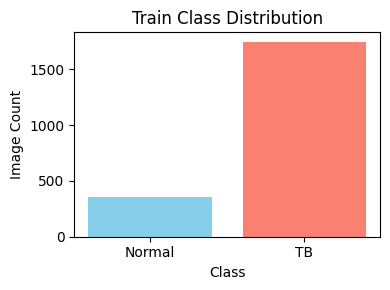

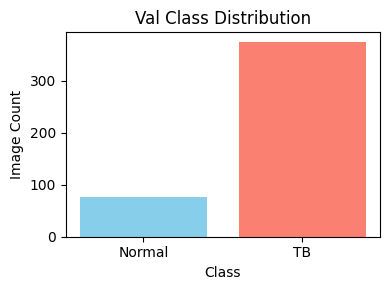

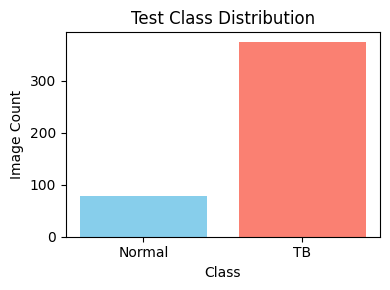

In [12]:
import os
import matplotlib.pyplot as plt

base_path = "/content/drive/MyDrive/TB/chest_xray"
splits = ['train', 'val', 'test']
categories = ['Normal', 'TB']

for split in splits:
    counts = {}
    for cat in categories:
        folder = os.path.join(base_path, split, cat)
        counts[cat] = len(os.listdir(folder))
    # Plot
    plt.figure(figsize=(4, 3))
    plt.bar(counts.keys(), counts.values(), color=['skyblue', 'salmon'])
    plt.title(f"{split.capitalize()} Class Distribution")
    plt.ylabel("Image Count")
    plt.xlabel("Class")
    plt.tight_layout()
    plt.show()


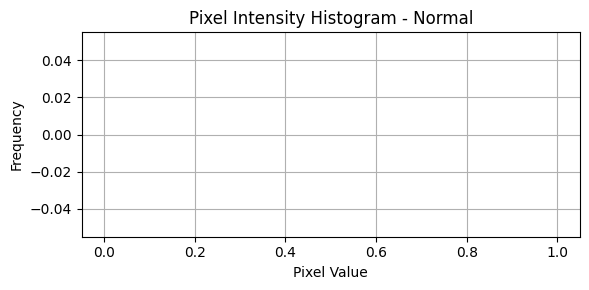

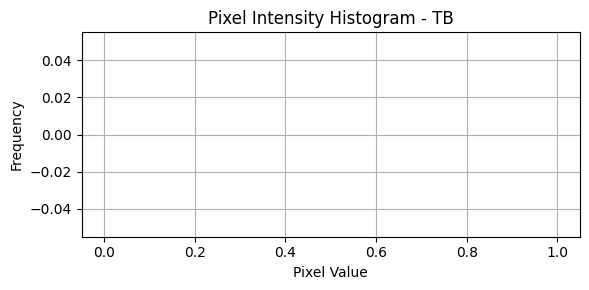

In [13]:
from PIL import Image
import numpy as np

def plot_pixel_histogram(folder_path, label, sample_limit=100):
    files = os.listdir(folder_path)[:sample_limit]
    pixel_values = []
    for file in files:
        try:
            img = Image.open(os.path.join(folder_path, file)).convert('L')
            pixel_values.extend(np.array(img).flatten())
        except:
            continue

    plt.figure(figsize=(6, 3))
    plt.hist(pixel_values, bins=50, color='gray')
    plt.title(f"Pixel Intensity Histogram - {label}")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Histogram for each class
plot_pixel_histogram("/content/drive/MyDrive/TB/chest_xray/train", "Normal")
plot_pixel_histogram("/content/drive/MyDrive/TB/chest_xray/train", "TB")


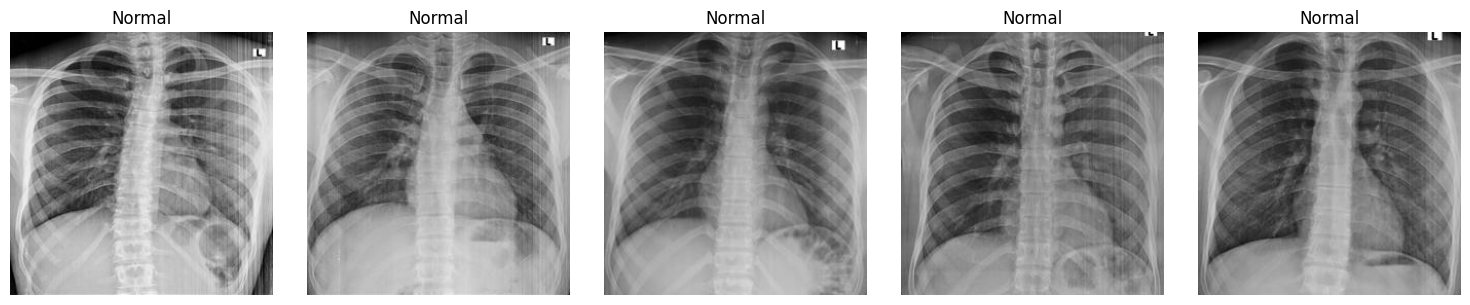

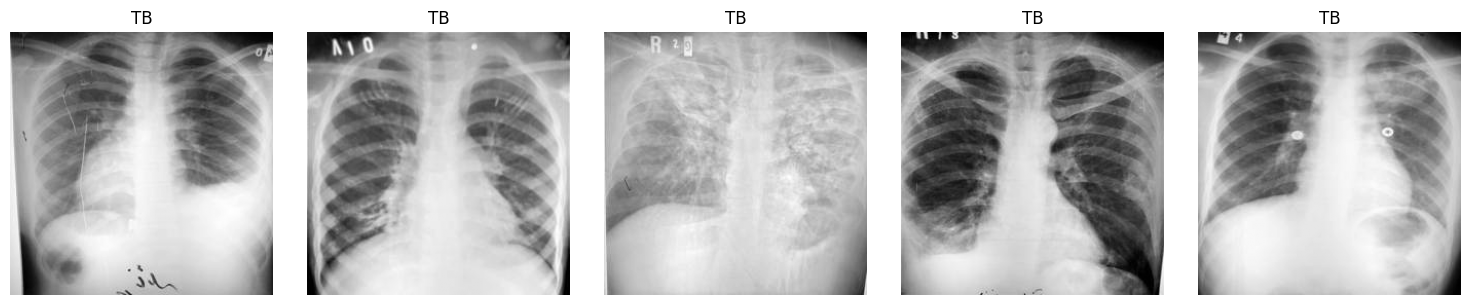

In [14]:
def show_sample_images(folder_path, label, n=5):
    files = os.listdir(folder_path)[:n]
    plt.figure(figsize=(15, 3))
    for i, file in enumerate(files):
        img = Image.open(os.path.join(folder_path, file)).convert('L')
        plt.subplot(1, n, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(label)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display sample images
show_sample_images("/content/drive/MyDrive/TB/chest_xray/train/Normal", "Normal")
show_sample_images("/content/drive/MyDrive/TB/chest_xray/train/TB", "TB")


In [15]:
from collections import Counter

def count_all_images(base_path):
    splits = ['train', 'val', 'test']
    categories = ['Normal', 'TB']
    for split in splits:
        print(f"\n🔹 {split.upper()} SPLIT:")
        for cat in categories:
            folder = os.path.join(base_path, split, cat)
            print(f"{cat}: {len(os.listdir(folder))} images")

count_all_images("/content/drive/MyDrive/TB/chest_xray")



🔹 TRAIN SPLIT:
Normal: 359 images
TB: 1745 images

🔹 VAL SPLIT:
Normal: 77 images
TB: 374 images

🔹 TEST SPLIT:
Normal: 78 images
TB: 375 images


In [16]:
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50, VGG16, EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [17]:
def build_and_train_model(base_model_fn, model_name, dropout_rate=0.5, dense_units=128, learning_rate=0.0001):
    # Load base model (frozen)
    base_model = base_model_fn(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = False

    # Add custom head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(dense_units, activation='relu')(x)
    x = Dropout(dropout_rate / 2)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)

    # Compile
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Callbacks
    os.makedirs("models", exist_ok=True)
    checkpoint = ModelCheckpoint(f"models/{model_name}.h5", monitor='val_accuracy', save_best_only=True)
    early_stop = EarlyStopping(monitor='val_loss', patience=5)

    # Train
    history = model.fit(train_data,
                        validation_data=val_data,
                        epochs=20,
                        callbacks=[checkpoint, early_stop])

    return model, history


In [18]:
# ResNet50
resnet_model, resnet_hist = build_and_train_model(ResNet50, "ResNet50", dropout_rate=0.5)

# VGG16
vgg_model, vgg_hist = build_and_train_model(VGG16, "VGG16", dropout_rate=0.4)

# EfficientNetB0
efficientnet_model, effnet_hist = build_and_train_model(EfficientNetB0, "EfficientNetB0", dropout_rate=0.3)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.7521 - loss: 0.5594

66/66 ━━━━━━━━━━━━━━━━━━━━ 64s 733ms/step - accuracy: 0.7528 - loss: 0.5587 - val_accuracy: 0.8293 - val_loss: 0.4583
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 35s 524ms/step - accuracy: 0.8103 - loss: 0.5086 - val_accuracy: 0.8293 - val_loss: 0.4574
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 33s 505ms/step - accuracy: 0.8289 - loss: 0.4934 - val_accuracy: 0.8293 - val_loss: 0.4562
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 35s 528ms/step - accuracy: 0.8299 - loss: 0.4881 - val_accuracy: 0.8293 - val_loss: 0.4553
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 34s 508ms/step - accuracy: 0.8417 - loss: 0.4496 - val_accuracy: 0.8293 - val_loss: 0.4554
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 35s 535ms/step - accuracy: 0.8298 - loss: 0.4798 - val_accuracy: 0.8293 - val_loss: 0.4588
Epoch 7/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 34s 519ms/step - accuracy: 0.8273 - loss: 0.4697 - val_accuracy: 0.8293 - val_loss: 0.4577
Epoch 8/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 42s 529ms/step - accuracy: 0.8249 - loss: 0.4839 - val_accuracy: 0.829

66/66 ━━━━━━━━━━━━━━━━━━━━ 68s 795ms/step - accuracy: 0.5587 - loss: 0.6949 - val_accuracy: 0.8293 - val_loss: 0.4407
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 36s 548ms/step - accuracy: 0.8285 - loss: 0.4635 - val_accuracy: 0.8293 - val_loss: 0.4131
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 36s 537ms/step - accuracy: 0.8375 - loss: 0.4162 - val_accuracy: 0.8293 - val_loss: 0.3851
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 36s 550ms/step - accuracy: 0.8501 - loss: 0.3776 - val_accuracy: 0.8293 - val_loss: 0.3544
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 37s 552ms/step - accuracy: 0.8300 - loss: 0.3724 - val_accuracy: 0.8293 - val_loss: 0.3255
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.8212 - loss: 0.3684

66/66 ━━━━━━━━━━━━━━━━━━━━ 36s 538ms/step - accuracy: 0.8215 - loss: 0.3681 - val_accuracy: 0.8359 - val_loss: 0.3011
Epoch 7/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.8288 - loss: 0.3539

66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 541ms/step - accuracy: 0.8291 - loss: 0.3535 - val_accuracy: 0.8692 - val_loss: 0.2834
Epoch 8/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.8638 - loss: 0.2981

66/66 ━━━━━━━━━━━━━━━━━━━━ 42s 552ms/step - accuracy: 0.8637 - loss: 0.2981 - val_accuracy: 0.8958 - val_loss: 0.2649
Epoch 9/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.8596 - loss: 0.2926

66/66 ━━━━━━━━━━━━━━━━━━━━ 36s 539ms/step - accuracy: 0.8597 - loss: 0.2926 - val_accuracy: 0.9180 - val_loss: 0.2496
Epoch 10/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.8804 - loss: 0.2656

66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 544ms/step - accuracy: 0.8803 - loss: 0.2658 - val_accuracy: 0.9224 - val_loss: 0.2350
Epoch 11/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 36s 542ms/step - accuracy: 0.8837 - loss: 0.2595 - val_accuracy: 0.9202 - val_loss: 0.2258
Epoch 12/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - accuracy: 0.8973 - loss: 0.2527

66/66 ━━━━━━━━━━━━━━━━━━━━ 37s 554ms/step - accuracy: 0.8972 - loss: 0.2526 - val_accuracy: 0.9290 - val_loss: 0.2217
Epoch 13/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.8917 - loss: 0.2438

66/66 ━━━━━━━━━━━━━━━━━━━━ 37s 555ms/step - accuracy: 0.8916 - loss: 0.2438 - val_accuracy: 0.9313 - val_loss: 0.2095
Epoch 14/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.9070 - loss: 0.2201

66/66 ━━━━━━━━━━━━━━━━━━━━ 36s 538ms/step - accuracy: 0.9069 - loss: 0.2201 - val_accuracy: 0.9335 - val_loss: 0.1996
Epoch 15/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 42s 549ms/step - accuracy: 0.9109 - loss: 0.2157 - val_accuracy: 0.9313 - val_loss: 0.1925
Epoch 16/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.9168 - loss: 0.2056

66/66 ━━━━━━━━━━━━━━━━━━━━ 36s 541ms/step - accuracy: 0.9166 - loss: 0.2059 - val_accuracy: 0.9424 - val_loss: 0.1931
Epoch 17/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 37s 551ms/step - accuracy: 0.9014 - loss: 0.2173 - val_accuracy: 0.9379 - val_loss: 0.1762
Epoch 18/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 37s 556ms/step - accuracy: 0.9068 - loss: 0.2119 - val_accuracy: 0.9424 - val_loss: 0.1797
Epoch 19/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 36s 543ms/step - accuracy: 0.9214 - loss: 0.1912 - val_accuracy: 0.9424 - val_loss: 0.1728
Epoch 20/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.9210 - loss: 0.1920

66/66 ━━━━━━━━━━━━━━━━━━━━ 36s 539ms/step - accuracy: 0.9209 - loss: 0.1920 - val_accuracy: 0.9446 - val_loss: 0.1746
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 698ms/step - accuracy: 0.7749 - loss: 0.5349

66/66 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.7755 - loss: 0.5340 - val_accuracy: 0.8293 - val_loss: 0.4587
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 33s 503ms/step - accuracy: 0.8219 - loss: 0.4722 - val_accuracy: 0.8293 - val_loss: 0.4568
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 33s 504ms/step - accuracy: 0.8263 - loss: 0.4688 - val_accuracy: 0.8293 - val_loss: 0.4569
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 32s 488ms/step - accuracy: 0.8223 - loss: 0.4711 - val_accuracy: 0.8293 - val_loss: 0.4575
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 33s 497ms/step - accuracy: 0.8387 - loss: 0.4463 - val_accuracy: 0.8293 - val_loss: 0.4576
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 32s 491ms/step - accuracy: 0.8290 - loss: 0.4611 - val_accuracy: 0.8293 - val_loss: 0.4585
Epoch 7/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 32s 489ms/step - accuracy: 0.8214 - loss: 0.4726 - val_accuracy: 0.8293 - val_loss: 0.4588


In [19]:
import matplotlib.pyplot as plt

def plot_training(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Train Acc')
    plt.plot(epochs, val_acc, 'r', label='Val Acc')
    plt.title(f'{model_name} Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Train Loss')
    plt.plot(epochs, val_loss, 'r', label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()


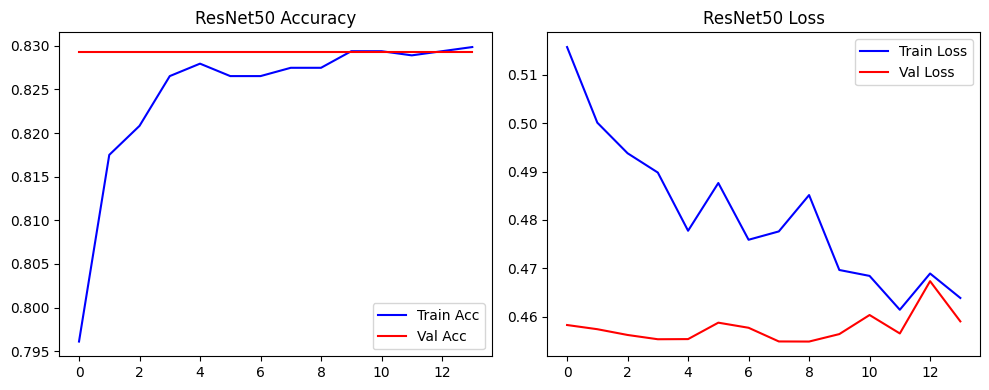

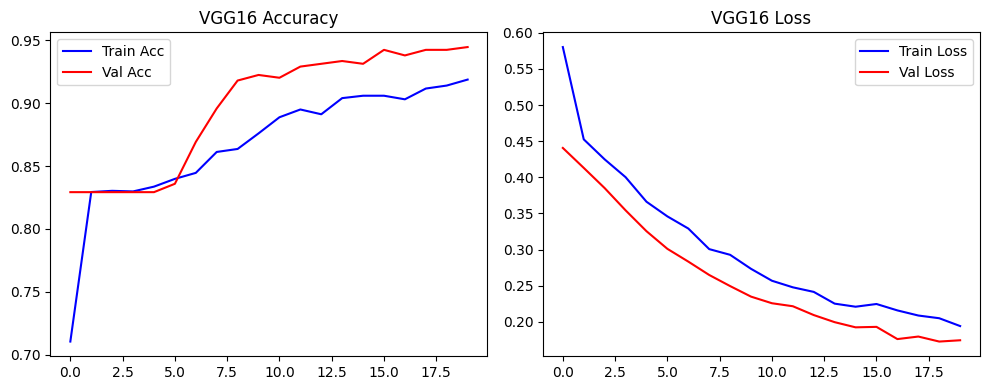

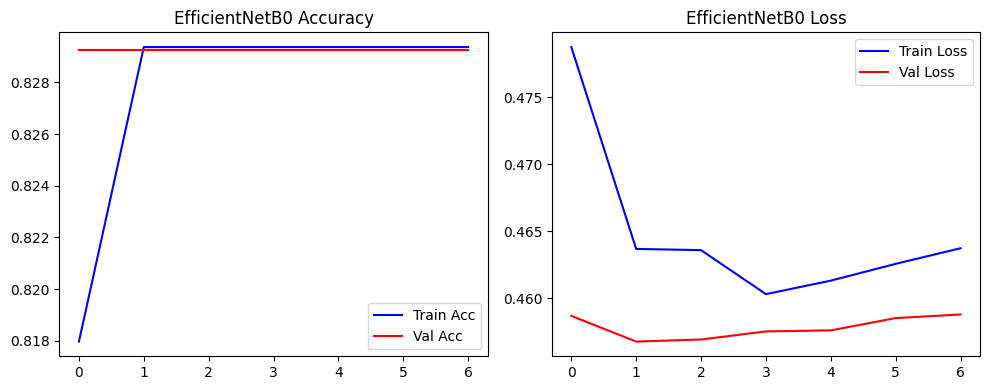

In [20]:
plot_training(resnet_hist, "ResNet50")
plot_training(vgg_hist, "VGG16")
plot_training(effnet_hist, "EfficientNetB0")


In [21]:
checkpoint = ModelCheckpoint(
    "models/ResNet50.keras",
    monitor='val_accuracy',
    save_best_only=True
)


In [22]:
resnet_model.save("models/ResNet50.keras")
vgg_model.save("models/VGG16.keras")
efficientnet_model.save("models/EfficientNetB0.keras")

In [23]:
from tensorflow.keras.models import load_model

# Load ResNet50
resnet_model = load_model("models/ResNet50.keras")

# Load VGG16
vgg_model = load_model("models/VGG16.keras")

# Load EfficientNetB0
effnet_model = load_model("models/EfficientNetB0.keras")


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [24]:
# Evaluate on test data
resnet_loss, resnet_acc = resnet_model.evaluate(test_data)
vgg_loss, vgg_acc = vgg_model.evaluate(test_data)
effnet_loss, effnet_acc = effnet_model.evaluate(test_data)

# Print comparison
print(" Model Performance on Test Set:")
print(f"ResNet50       → Accuracy: {resnet_acc:.4f}, Loss: {resnet_loss:.4f}")
print(f"VGG16          → Accuracy: {vgg_acc:.4f}, Loss: {vgg_loss:.4f}")
print(f"EfficientNetB0 → Accuracy: {effnet_acc:.4f}, Loss: {effnet_loss:.4f}")


15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 309ms/step - accuracy: 0.5866 - loss: 0.7658
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 417ms/step - accuracy: 0.9405 - loss: 0.2025
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 823ms/step - accuracy: 0.5866 - loss: 0.8848
 Model Performance on Test Set:
ResNet50       → Accuracy: 0.8278, Loss: 0.4605
VGG16          → Accuracy: 0.9448, Loss: 0.1694
EfficientNetB0 → Accuracy: 0.8278, Loss: 0.4614


15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 360ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 221ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 605ms/step


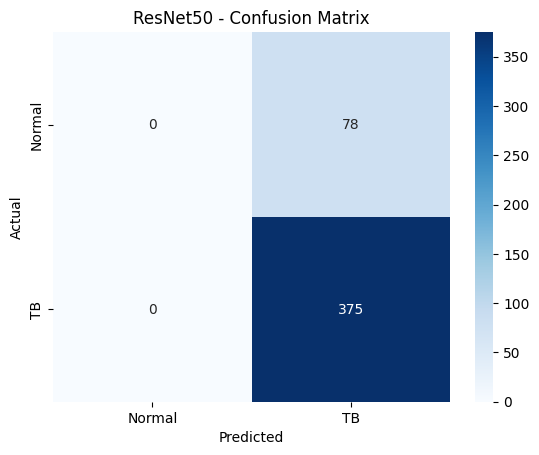

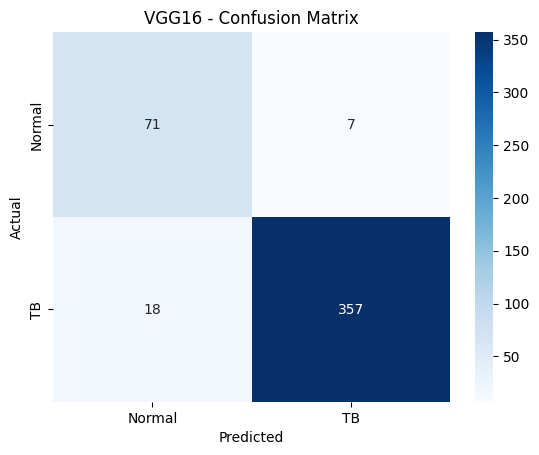

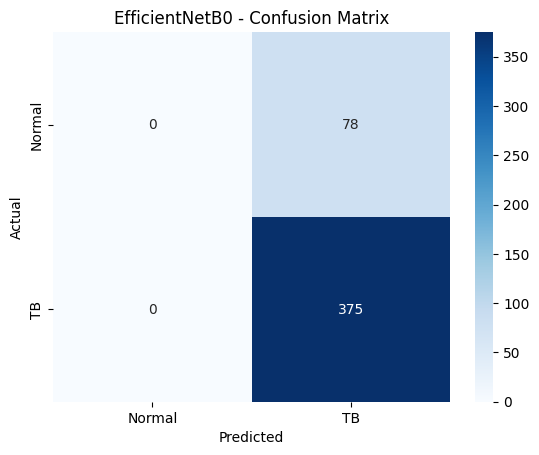

ResNet50:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        78
           1       0.83      1.00      0.91       375

    accuracy                           0.83       453
   macro avg       0.41      0.50      0.45       453
weighted avg       0.69      0.83      0.75       453

VGG16:
               precision    recall  f1-score   support

           0       0.80      0.91      0.85        78
           1       0.98      0.95      0.97       375

    accuracy                           0.94       453
   macro avg       0.89      0.93      0.91       453
weighted avg       0.95      0.94      0.95       453

EfficientNetB0:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        78
           1       0.83      1.00      0.91       375

    accuracy                           0.83       453
   macro avg       0.41      0.50      0.45       453
weighted avg       0.69      0.83     

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Get true labels
y_true = test_data.classes

# Get predicted probabilities and round to 0 or 1
y_pred_resnet = (resnet_model.predict(test_data) > 0.5).astype("int32")
y_pred_vgg = (vgg_model.predict(test_data) > 0.5).astype("int32")
y_pred_effnet = (effnet_model.predict(test_data) > 0.5).astype("int32")

# Function to plot confusion matrix
def plot_confusion(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'TB'], yticklabels=['Normal', 'TB'])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot for each model
plot_confusion(y_true, y_pred_resnet, "ResNet50")
plot_confusion(y_true, y_pred_vgg, "VGG16")
plot_confusion(y_true, y_pred_effnet, "EfficientNetB0")

# Classification report
print("ResNet50:\n", classification_report(y_true, y_pred_resnet))
print("VGG16:\n", classification_report(y_true, y_pred_vgg))
print("EfficientNetB0:\n", classification_report(y_true, y_pred_effnet))


In [69]:
!pip install streamlit pyngrok tensorflow pillow


In [70]:
%%writefile TB_detector_app.py
import streamlit as st
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from PIL import Image

# Load model once
@st.cache_resource
def load_vgg16_model():
    return load_model("models/VGG16.keras")

model = load_vgg16_model()

# Preprocess uploaded image
def preprocess_xray(uploaded_file):
    img = Image.open(uploaded_file).convert("RGB")
    img = img.resize((224, 224))
    img_array = image.img_to_array(img) / 255.0
    return np.expand_dims(img_array, axis=0)

# Predict
def predict_tb(img_array):
    prediction = model.predict(img_array)[0][0]
    confidence = prediction if prediction > 0.5 else 1 - prediction
    label = "Tuberculosis" if prediction > 0.5 else "Normal"
    return label, confidence

# Sidebar navigation
st.sidebar.title(" Navigation")
page = st.sidebar.radio("Go to", ["Project Introduction", "Upload & Predict"])

# Page 1: Project Introduction

if page == "Project Introduction":
    st.title(" Chest X-ray TB Detection using Deep Learning")
    st.markdown("""
    This project uses a **VGG16 deep learning model** trained on over 3000 chest X-ray images to detect signs of **Tuberculosis (TB)**.

    ###  Dataset Info:
    - Total X-ray images: 3008
    - TB-positive: 2494
    - Normal: 514

    ###  Key Features:
    - Transfer Learning with VGG16
    - Data augmentation and preprocessing
    - High accuracy on unseen data
    - Simple upload-and-predict web app interface

    """)


# Page 2: Upload & Predict

elif page == "Upload & Predict":
    st.title(" Upload Chest X-ray")
    st.markdown("Upload a chest X-ray image to predict if it's **Normal** or shows signs of **Tuberculosis**.")

    uploaded_file = st.file_uploader("Choose an X-ray image", type=["jpg", "jpeg", "png"])

    if uploaded_file is not None:
        st.image(uploaded_file, caption="Uploaded X-ray", use_container_width=True)

        img_array = preprocess_xray(uploaded_file)
        label, confidence = predict_tb(img_array)

        st.markdown(f"###  Prediction: **{label}**")
        st.markdown(f"**Confidence:** {confidence * 100:.2f}%")




Overwriting TB_detector_app.py


In [71]:
from pyngrok import ngrok
import threading, os

# Kill any previous runs
!pkill streamlit

# Function to run Streamlit
def run_app():
    os.system("streamlit run TB_detector_app.py --server.port 8501")

# Start Streamlit in background
thread = threading.Thread(target=run_app)
thread.start()

# Expose the app using ngrok
public_url = ngrok.connect(8501)
print("Streamlit app running at:", public_url)


Streamlit app running at: NgrokTunnel: "https://10dd5dcbcff9.ngrok-free.app" -> "http://localhost:8501"


In [48]:
import os
os.getcwd()

'/content'